# Introducción

Este Notebook presenta el proceso de análisis y modelado para predecir la probabilidad de que un cliente contrate una em acount. Utilizaremos un conjunto de datos que contiene información sobre las características demográficas y de comportamiento de los clientes, así como sus interacciones previas con el banco.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Importación de librerías y carga de datos

Importamos las librerías necesarias para el análisis y modelado de datos. Pandas se utilizará para la manipulación de datos, NumPy para operaciones numéricas, sklearn para el modelado y matplotlib para la visualización de datos.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from pandas.tseries.offsets import DateOffset
from sklearn import metrics
import matplotlib.pyplot as plt

# 2. Cargar y revisar de los datos
Se carga el archivo CSV que contiene los datos y se utiliza el método info() para obtener una descripción general de los datos, incluyendo el número total de entradas y la cantidad de valores no nulos.

In [ ]:
csv_path = '/content/drive/MyDrive/Colab Notebooks/MDS - Grupo 7/Capstone/Dataset para trabajar 04.07/informacion_clientes.csv'

In [ ]:
# Cargar los datos
df_ema = pd.read_csv(csv_path)

<ipython-input-8-859d3b6634d1>:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ema = pd.read_csv(csv_path)


In [ ]:
df_ema.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 27 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   pk_cid                  int64  
 1   pk_partition            object 
 2   entry_date              object 
 3   entry_channel           object 
 4   active_customer         int64  
 5   segment                 object 
 6   short_term_deposit      int64  
 7   loans                   int64  
 8   mortgage                int64  
 9   funds                   int64  
 10  securities              int64  
 11  long_term_deposit       int64  
 12  credit_card             int64  
 13  payroll                 int64  
 14  pension_plan            int64  
 15  payroll_account         int64  
 16  emc_account             int64  
 17  debit_card              int64  
 18  em_acount               int64  
 19  country_id              object 
 20  region_code             object 
 21  gender                  object 

Definimos el em_acount como objetivo para realizar las acciones posteriores

In [ ]:
target = "em_acount"

# 3. Preprocesamiento y preparación de los datos
Se procesan los datos para prepararlos para el análisis. Esto incluye la ordenación de los datos por cliente y mes, la creación de nuevas columnas que indican si el cliente ha comprado en el mes anterior y hace dos meses, y la conversión de la columna de fecha a tipo datetime.

In [ ]:
df_ema[target].value_counts()

1    4381602
0    1581322
Name: em_acount, dtype: int64

In [ ]:
# Convertir la columna 'month_sale' a tipo de dato datetime
df_ema['pk_partition'] = pd.to_datetime(df_ema['pk_partition'])

In [ ]:
df_ema['Suma_productos_activos']= df_ema['Suma_productos_activos'] - df_ema[target]

# 4. Creación del conjunto de datos balanceado
Aquí se utiliza la función create_dataset, la cual definimos para crear un conjunto de datos balanceado.

In [ ]:
def create_dataset(df):
    dataset_ema = pd.DataFrame()  # Crear un DataFrame vacío para almacenar los datos muestreados
    selected_cids = set()  # Crear un conjunto para almacenar los cids seleccionados

    months = sorted(df['pk_partition'].unique())  # Almacena los meses únicos en la columna 'month_sale', en orden
    for month in months[:-1]:  # Iterar sobre todos los meses, excepto el último
        month_df = df[df['pk_partition'] == month]  # Filtrar el DataFrame original para el mes actual
        # Excluir los cids que ya han sido seleccionados
        data_with_purchase = month_df[(month_df[target] == 1) & (~month_df['pk_cid'].isin(selected_cids))]
        data_without_purchase = month_df[(month_df[target] == 0) & (~month_df['pk_cid'].isin(selected_cids))]
        sample_size = min(len(data_with_purchase), len(data_without_purchase))  # Calcular el tamaño de muestra mínimo

        print(f'Mes: {month}')  # Imprimir el mes actual
        print(f'Número de 1s: {len(data_with_purchase)}')  # Imprimir el número de 1s para el mes actual
        print(f'Número de 0s: {len(data_without_purchase)}')  # Imprimir el número de 0s para el mes actual
        print(f'Tamaño de la muestra: {sample_size}\n')  # Imprimir el tamaño de la muestra para el mes actual

        if sample_size > 0:  # Verificar que haya suficientes clientes en ambas categorías para crear un dataset equilibrado
            sampled_data_with_purchase = data_with_purchase.sample(n=sample_size, random_state=42)  # Tomar sample_size datos de los clientes que compraron
            sampled_data_without_purchase = data_without_purchase.sample(n=sample_size, random_state=42)  # Tomar sample_size datos de los clientes que no compraron
            sampled_data = pd.concat([sampled_data_with_purchase, sampled_data_without_purchase])  # Concatenar los datos muestreados
            dataset_ema = pd.concat([dataset_ema, sampled_data])  # Agregar los datos muestreados al dataset final
            # Actualizar los cids seleccionados
            selected_cids.update(sampled_data['pk_cid'].values)

    # Tratar el último mes por separado
    last_month = months[-1]
    last_month_df = df[df['pk_partition'] == last_month]  # Filtrar el DataFrame original para el último mes
    # Aquí no necesitamos equilibrar los datos, así que simplemente excluimos los cids que ya han sido seleccionados
    last_month_data = last_month_df[~last_month_df['pk_cid'].isin(selected_cids)]

    # Imprimir las estadísticas del último mes
    print(f'Mes: {last_month}')
    print(f'Número de 1s: {len(last_month_data[last_month_data[target] == 1])}')
    print(f'Número de 0s: {len(last_month_data[last_month_data[target] == 0])}')

    # Agregar los datos del último mes al dataset final
    dataset_ema = pd.concat([dataset_ema, last_month_data])

    return dataset_ema  # Devolver el dataset consolidado de todos los meses

In [ ]:
# Crear el dataset por meses y consolidar las ventas
dataset_ema = create_dataset(df_ema)

Mes: 2018-01-01T00:00:00.000000000
Número de 1s: 215293
Número de 0s: 24200
Tamaño de la muestra: 24200

Mes: 2018-02-01T00:00:00.000000000
Número de 1s: 192283
Número de 0s: 2577
Tamaño de la muestra: 2577

Mes: 2018-03-01T00:00:00.000000000
Número de 1s: 190685
Número de 0s: 2432
Tamaño de la muestra: 2432

Mes: 2018-04-01T00:00:00.000000000
Número de 1s: 188897
Número de 0s: 2279
Tamaño de la muestra: 2279

Mes: 2018-05-01T00:00:00.000000000
Número de 1s: 187584
Número de 0s: 2071
Tamaño de la muestra: 2071

Mes: 2018-06-01T00:00:00.000000000
Número de 1s: 186149
Número de 0s: 2161
Tamaño de la muestra: 2161

Mes: 2018-07-01T00:00:00.000000000
Número de 1s: 193820
Número de 0s: 74079
Tamaño de la muestra: 74079

Mes: 2018-08-01T00:00:00.000000000
Número de 1s: 129045
Número de 0s: 5288
Tamaño de la muestra: 5288

Mes: 2018-09-01T00:00:00.000000000
Número de 1s: 138066
Número de 0s: 9031
Tamaño de la muestra: 9031

Mes: 2018-10-01T00:00:00.000000000
Número de 1s: 143310
Número de 0s:

In [ ]:
dataset_ema[target].value_counts()

1    279988
0    176295
Name: em_acount, dtype: int64

In [ ]:
dataset_ema.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456283 entries, 137961 to 5962923
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   pk_cid                  456283 non-null  int64         
 1   pk_partition            456283 non-null  datetime64[ns]
 2   entry_date              456283 non-null  object        
 3   entry_channel           456283 non-null  object        
 4   active_customer         456283 non-null  int64         
 5   segment                 456283 non-null  object        
 6   short_term_deposit      456283 non-null  int64         
 7   loans                   456283 non-null  int64         
 8   mortgage                456283 non-null  int64         
 9   funds                   456283 non-null  int64         
 10  securities              456283 non-null  int64         
 11  long_term_deposit       456283 non-null  int64         
 12  credit_card             

In [ ]:
last_month = dataset_ema['pk_partition'].max()
dataset_ema['is_last_month'] = (dataset_ema['pk_partition'] == last_month).astype(int)

# 5. Adición de nuevas columnas y agrupación de los datos
Se añade una nueva columna que indica si los datos corresponden al último mes. Luego, se agrupan los datos por cliente, obteniendo el último valor de cada cliente para cada producto y el promedio de sus salarios.

In [ ]:
# Agrupar los datos por 'pk_cid', incluyendo la nueva columna en la operación de agrupamiento
df_grouped_ema = dataset_ema.groupby('pk_cid').agg({
    #'pension_plan': 'last',
    #'net_margin': 'sum',
    'age': 'max',
    'salary': 'mean',
    'entry_channel': 'last',
    'segment': 'last',
    'gender': 'last',
    #'region_code': 'last',
    #'country_id':'last',
   #'días_para_compra':'mean',
    'Suma_productos_activos':'max',
   # 'short_term_deposit': 'last',
   # 'loans': 'last',
   # 'mortgage': 'last',
   # 'funds': 'last',
   # 'securities': 'last',
   #'long_term_deposit': 'last',
   #'em_account_pp': 'last',
   # 'credit_card': 'last',
   # 'payroll': 'last',
   # 'pension_plan': 'last',
   # 'payroll_account': 'last',
   # 'emc_account': 'last',
   # 'debit_card': 'last',
   # 'em_account_p': 'last',
    'em_acount': 'last',
    'pk_partition':'max'  # Agregar la nueva columna
}).reset_index()

In [ ]:
# df_grouped_ema['region_code'] = df_grouped_ema['region_code'].astype(str)

In [ ]:
df_grouped_ema.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456283 entries, 0 to 456282
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   pk_cid                  456283 non-null  int64         
 1   age                     456283 non-null  int64         
 2   salary                  456283 non-null  float64       
 3   entry_channel           456283 non-null  object        
 4   segment                 456283 non-null  object        
 5   gender                  456283 non-null  object        
 6   Suma_productos_activos  456283 non-null  int64         
 7   em_acount               456283 non-null  int64         
 8   pk_partition            456283 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 31.3+ MB


# 6. Codificación de variables categóricas
Las variables categóricas como el canal de entrada, el segmento y el género se codifican utilizando One-Hot Encoding para convertirlas en un formato que pueda ser utilizado por el modelo de machine learning.

In [ ]:
df_grouped_ema = pd.get_dummies(df_grouped_ema, columns=['entry_channel', 'segment', 'gender'])#, 'region_code', 'country_id'])


In [ ]:
df_grouped_ema.head()

,pk_cid,age,salary,Suma_productos_activos,em_acount,pk_partition,entry_channel_004,entry_channel_007,entry_channel_013,entry_channel_KAA,...,entry_channel_KHQ,entry_channel_No_data,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_no_indica,gender_H,gender_M,gender_no_data
0,15891,59,126179.0,0,1,2018-07-01,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,16063,62,126179.0,0,0,2018-11-01,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,16203,70,124622.0,0,0,2018-12-01,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,16502,57,126179.0,0,0,2018-09-01,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
4,17457,53,102406.0,1,1,2018-01-01,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


# 7. División de los datos en conjuntos de entrenamiento, prueba y validación
Los datos se dividen en conjuntos de entrenamiento, prueba y validación, utilizando diferentes meses para cada conjunto. También se normalizan las características numéricas en estos conjuntos.

In [ ]:
# Convertir 'month_sale' a tipo de fecha
df_grouped_ema['pk_partition'] = pd.to_datetime(df_grouped_ema['pk_partition'])

# Ordenar el DataFrame por 'month_sale'
df_grouped_ema = df_grouped_ema.sort_values(by='pk_partition')

# Definir las características y el objetivo
features = df_grouped_ema.columns.tolist()
features.remove(target)
features.remove('pk_partition')  # No queremos incluir la fecha como una característica

# Separar el conjunto de datos en características y objetivo
X = df_grouped_ema[features]
y = df_grouped_ema[target]

# Determinar el último, penúltimo y antepenúltimo mes de datos
last_month = df_grouped_ema['pk_partition'].max()
second_last_month = last_month - DateOffset(months=1)
third_last_month = last_month - DateOffset(months=2)

# Crear los conjuntos de datos de entrenamiento, validación y prueba
#train_df = df_grouped[df_grouped['pk_partition'] < third_last_month]
#test_df = df_grouped[(df_grouped['pk_partition'] >= third_last_month) & (df_grouped['pk_partition'] < last_month)]
train_df = df_grouped_ema[df_grouped_ema['pk_partition'] < second_last_month]
test_df = df_grouped_ema[df_grouped_ema['pk_partition'] == second_last_month]
val_df = df_grouped_ema[df_grouped_ema['pk_partition'] == last_month]

# Extraer las características y los objetivos de los conjuntos de entrenamiento, validación y prueba
X_train = train_df[features].copy()
y_train = train_df[target].copy()
X_test = test_df[features].copy()
y_test = test_df[target].copy()
X_val = val_df[features].copy()
y_val = val_df[target].copy()

# Normalizar las características numéricas en los conjuntos de entrenamiento, validación y prueba
numeric_features = ['age', 'salary', 'Suma_productos_activos'] #'días_para_compra',,'Suma_productos_activos']
scaler = StandardScaler()
X_train.loc[:, numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test.loc[:, numeric_features] = scaler.transform(X_test[numeric_features])
X_val.loc[:, numeric_features] = scaler.transform(X_val[numeric_features])

In [ ]:
# Entrenar el modelo
model = RandomForestClassifier(bootstrap= False, criterion= 'gini', n_estimators=54, max_depth=10, random_state=42)
model.fit(X_train, y_train)
# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = model.predict(X_train)
print("=== Resultados en el conjunto de entrenamiento ===")
print(classification_report(y_train, y_train_pred))
print("AUC-ROC:", roc_auc_score(y_train, y_train_pred))

# Evaluar el modelo en el conjunto de prueba
y_test_pred = model.predict(X_test)
print("=== Resultados en el conjunto de prueba ===")
print(classification_report(y_test, y_test_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_test_pred))

# Evaluar el modelo en el conjunto de validación
y_val_pred = model.predict(X_val)
print("=== Resultados en el conjunto de validación ===")
print(classification_report(y_val, y_val_pred))
print("AUC-ROC:", roc_auc_score(y_val, y_val_pred))

=== Resultados en el conjunto de entrenamiento ===
              precision    recall  f1-score   support

           0       0.75      0.74      0.75    167946
           1       0.75      0.76      0.75    167946

    accuracy                           0.75    335892
   macro avg       0.75      0.75      0.75    335892
weighted avg       0.75      0.75      0.75    335892

AUC-ROC: 0.7500952687173258
=== Resultados en el conjunto de prueba ===
              precision    recall  f1-score   support

           0       0.79      0.93      0.85      4159
           1       0.92      0.75      0.82      4159

    accuracy                           0.84      8318
   macro avg       0.85      0.84      0.84      8318
weighted avg       0.85      0.84      0.84      8318

AUC-ROC: 0.839264246213032
=== Resultados en el conjunto de validación ===
              precision    recall  f1-score   support

           0       0.13      0.94      0.22      4190
           1       1.00      0.75      

In [ ]:
# Predicciones
y_test_pred = model.predict(X_test)
y_test_score = model.predict_proba(X_test)[:,1]

# Métricas
confusion_matrix = pd.crosstab(y_test, y_test_pred, rownames=['Actual'], colnames=['Predicted'])
accuracy = model.score(X_test, y_test)
f1 = metrics.f1_score(y_test, y_test_pred)
roc_auc = metrics.roc_auc_score(y_test, y_test_score)

# Imprimir las métricas
print("Confusion Matrix:\n", confusion_matrix)
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)

Confusion Matrix:
 Predicted     0     1
Actual               
0          3881   278
1          1059  3100
Accuracy: 0.839264246213032
F1-score: 0.8226084649064616
ROC-AUC: 0.9376841076929952


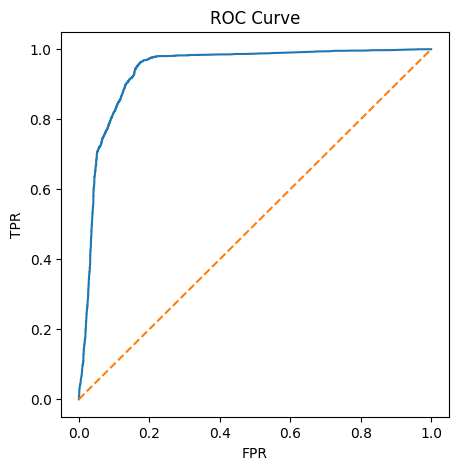

In [ ]:
# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_score)
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

In [ ]:
# Control del overfitting
for i in range(1,35):
    dt2 = RandomForestClassifier(max_depth=i, random_state=42, n_estimators=100)
    dt2.fit(X_train, y_train)
    acc_train = dt2.score(X_train, y_train)
    acc_test = dt2.score(X_test, y_test)
    print(f'Profundidad del arbol: {i}, Acc. train: {np.round(acc_train,3)}, Acc. test: {np.round(acc_test,3)}')

Profundidad del arbol: 1, Acc. train: 0.714, Acc. test: 0.82
Profundidad del arbol: 2, Acc. train: 0.72, Acc. test: 0.828
Profundidad del arbol: 3, Acc. train: 0.721, Acc. test: 0.83
Profundidad del arbol: 4, Acc. train: 0.726, Acc. test: 0.832
Profundidad del arbol: 5, Acc. train: 0.73, Acc. test: 0.838
Profundidad del arbol: 6, Acc. train: 0.73, Acc. test: 0.838
Profundidad del arbol: 7, Acc. train: 0.732, Acc. test: 0.838
Profundidad del arbol: 8, Acc. train: 0.734, Acc. test: 0.838
Profundidad del arbol: 9, Acc. train: 0.745, Acc. test: 0.838
Profundidad del arbol: 10, Acc. train: 0.749, Acc. test: 0.839
Profundidad del arbol: 11, Acc. train: 0.752, Acc. test: 0.839
Profundidad del arbol: 12, Acc. train: 0.757, Acc. test: 0.839
Profundidad del arbol: 13, Acc. train: 0.765, Acc. test: 0.839
Profundidad del arbol: 14, Acc. train: 0.77, Acc. test: 0.84
Profundidad del arbol: 15, Acc. train: 0.781, Acc. test: 0.84
Profundidad del arbol: 16, Acc. train: 0.788, Acc. test: 0.845
Profundid

In [ ]:
# Creamos el conjunto de datos para el último mes
last_month_df = df_grouped_ema[df_grouped_ema['pk_partition'] == last_month]

# Excluimos a los clientes que ya tienen un em_acount
last_month_df = last_month_df[last_month_df[target] == 0]

# Excluimos las ventas
X_last_month = last_month_df[features].copy()

# Normalizamos las características numéricas
X_last_month.loc[:, numeric_features] = scaler.transform(X_last_month[numeric_features])

# Hacemos las predicciones de probabilidad con el modelo
probs = model.predict_proba(X_last_month)

# Conservamos solo la probabilidad de la clase positiva
probs = probs[:, 1]

# Creamos un DataFrame para los resultados
results_ema = pd.DataFrame({
    'pk_cid': last_month_df['pk_cid'],  # reemplazar 'CustomerID' con tu columna de identificación de clientes
    'Probability_ema_acount': probs
})

# Ordenamos de mayor a menor probabilidad
results_ema = results_ema.sort_values(by='Probability_ema_acount', ascending=False)

# Mostramos los resultados
print(results_ema)

         pk_cid  Probability_ema_acount
382459  1468803                0.828269
383413  1469837                0.827436
396169  1483414                0.826946
413464  1501934                0.826739
388517  1475312                0.825106
...         ...                     ...
456277  1553684                0.049859
452879  1549254                0.049859
454221  1551012                0.049859
454347  1551178                0.049859
453178  1549645                0.049853

[4190 rows x 2 columns]


In [ ]:
results_ema[results_ema['Probability_ema_acount']>0.5]

,pk_cid,Probability_ema_acount
382459,1468803,0.828269
383413,1469837,0.827436
396169,1483414,0.826946
413464,1501934,0.826739
388517,1475312,0.825106
...,...,...
446797,1541480,0.519364
277417,1342535,0.516094
293199,1360631,0.514324
314813,1388841,0.510408


# 10. Búsqueda de hiperparámetros óptimos
Se realiza una búsqueda aleatoria de hiperparámetros para encontrar la mejor combinación de parámetros para el modelo de Random Forest.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

## Definir el rango de parámetros para la búsqueda aleatoria
param_dist = {"max_depth": randint(10, 15),
              "n_estimators": randint(50, 100),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Crear una nueva instancia del modelo RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=50, cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Ver los mejores parámetros encontrados
print("Mejores parámetros: ", random_search.best_params_)

# Utilizar el mejor modelo para hacer predicciones
best_rf = random_search.best_estimator_

Mejores parámetros:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'n_estimators': 54}


# 11. Análisis de correlación de las variables con el target
Se realiza un análisis de correlación para identificar las variables que tienen una mayor correlación con la variable objetivo, lo que puede indicar qué variables son más importantes para la predicción.

In [ ]:
correlation_with_target = df_grouped_ema.corr()[target]
correlation_with_target = correlation_with_target.drop(target)
sorted_correlations = correlation_with_target.sort_values(ascending=False)
print(sorted_correlations)

<ipython-input-39-bc2ef486a9d2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_target = df_grouped_ema.corr()[target]


segment_03 - UNIVERSITARIO    0.410936
entry_channel_KHE             0.290661
entry_channel_KHQ             0.221118
gender_M                      0.044114
entry_channel_KHM             0.029459
                                ...   
age                          -0.157832
entry_channel_KFC            -0.158155
Suma_productos_activos       -0.208724
entry_channel_No_data        -0.394856
segment_no_indica            -0.398480
Name: em_acount, Length: 79, dtype: float64


In [ ]:
corr = df_grouped_ema.corr()

<ipython-input-41-218095b78805>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_grouped_ema.corr()


In [ ]:
corr.style.background_gradient(cmap='coolwarm')

# 12. Descargamos el archivo con la propabilidad por cliente

In [ ]:
from google.colab import files

# Guardar el dataframe en un archivo CSV
results_ema.to_csv('results_ema.csv', index=False)

# Descargar el archivo CSV
files.download('results_ema.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>